<a href="https://colab.research.google.com/github/HarlinLee/PSC/blob/main/experiments/brain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pymanopt
!pip install geomstats

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 14.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
DRIVE_PATH = "/content/drive/MyDrive/PSC/PSC"
output_folder = "/content/drive/MyDrive/PSC/experiments"

import sys
sys.path.insert(0, DRIVE_PATH)

import scipy.io as sio

import numpy as np
from pymanopt.manifolds.stiefel import Stiefel
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D

from utils import rotation_mat, get_samples, dist_Gr, dist_St, projection_cost, nuc_cost
from projections import manopt_alpha, PCA, yhat_alpha_all

Mounted at /content/drive


INFO:root:Using numpy backend


# Load brain data

Muldoon SF, Pasqualetti F, Gu S, Cieslak M, Grafton ST, Vettel JM, et al. (2016) Stimulation-Based Control of Dynamic Brain Networks. PLoS Comput Biol 12(9): e1005076. https://doi.org/10.1371/journal.pcbi.1005076

In [ ]:
folder_name = 'connectivity_matrices'
fnames = []
netmat = {}
subjects = []

for i in range(1, 9):
    for j in range(1, 4):
        fnames.append(f'subject{i}_scan{j}.mat')
        subjects.append(i)

for fn in fnames:
    mat_contents = sio.loadmat(os.path.join(output_folder, folder_name, fn))
    netmat[fn] = mat_contents['connectivity_density_matrix']

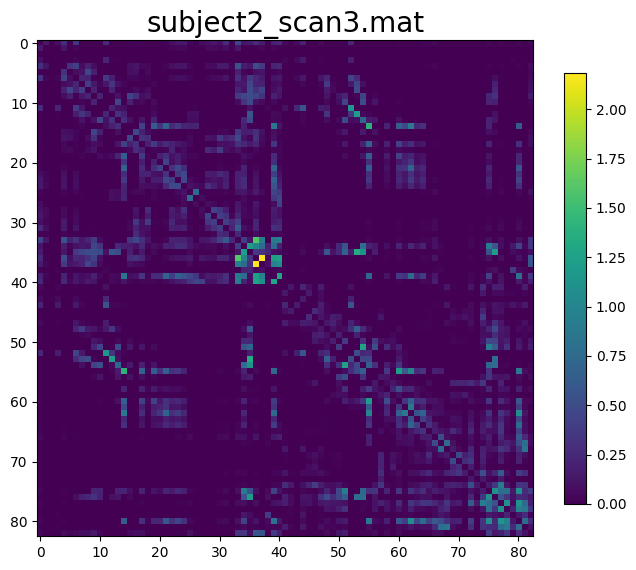

subject2_scan3.mat (83, 83)


In [ ]:
#visualize one brain data
idx = 5

plt.figure(figsize=(8, 8))
plt.title(fnames[idx], fontsize=20)
plt.imshow(netmat[fnames[idx]])
plt.colorbar(shrink=0.7)
plt.show()

print(fnames[idx], netmat[fnames[idx]].shape)

# Get data on Stiefel manifold from brain data

(83,) (83, 83)


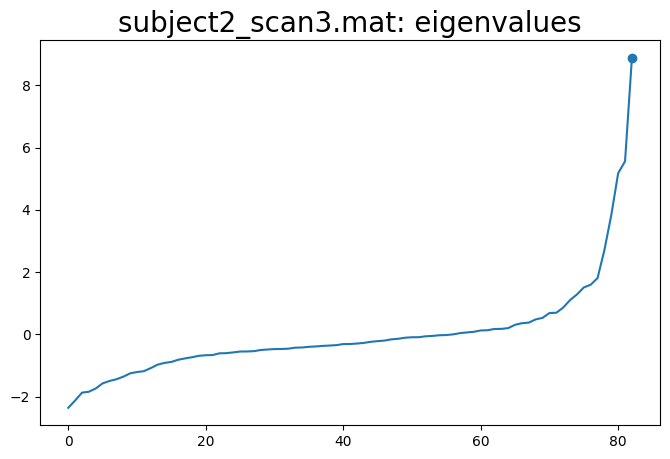

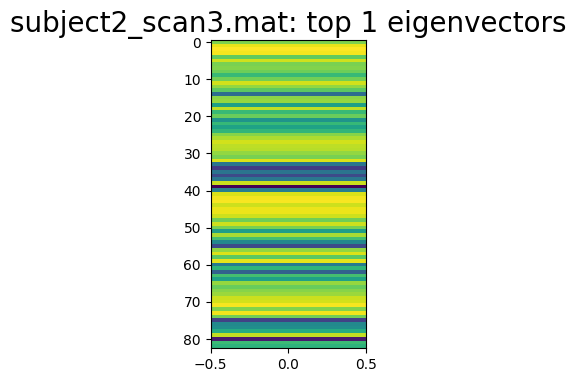

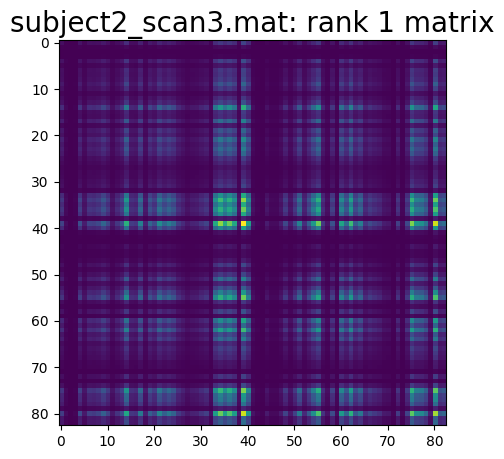

In [ ]:
N = netmat[fnames[0]].shape[0]
k = 1
n = 3
m = len(netmat)

ys = []

for fn, mat in netmat.items():
    w, v = np.linalg.eigh(mat)

    ys.append(v[:, -k:]) # eigenvectors of the connectivity matrix

    if fn == fnames[idx]:
        print(w.shape, v.shape)

        plt.figure(figsize=(8, 5))
        plt.plot(w)
        plt.scatter(len(w)-k, w[-k], marker='o')
        plt.title(f'{fn}: eigenvalues', fontsize=20)
        plt.show()

        plt.figure(figsize=(2, 4))
        plt.imshow(v[:, -k:], aspect='auto')
        plt.title(f'{fn}: top {k} eigenvectors', fontsize=20)
        plt.show()

        plt.figure(figsize=(5, 5))
        plt.imshow(v[:, -k:].dot(v[:, -k:].T), aspect='auto')
        plt.title(f'{fn}: rank {k} matrix', fontsize=20)
        plt.show()

## Visualize PSC

In [ ]:
ys = np.array(ys)
ys = ys - np.mean(ys, axis=0)

alpha_PCA = PCA(ys, n)
alpha_GD = manopt_alpha(ys, alpha_PCA)

X = yhat_alpha_all(alpha_GD, ys)
X = np.array(X).squeeze()

Optimizing...
Terminated - min grad norm reached after 560 iterations, 16.64 seconds.



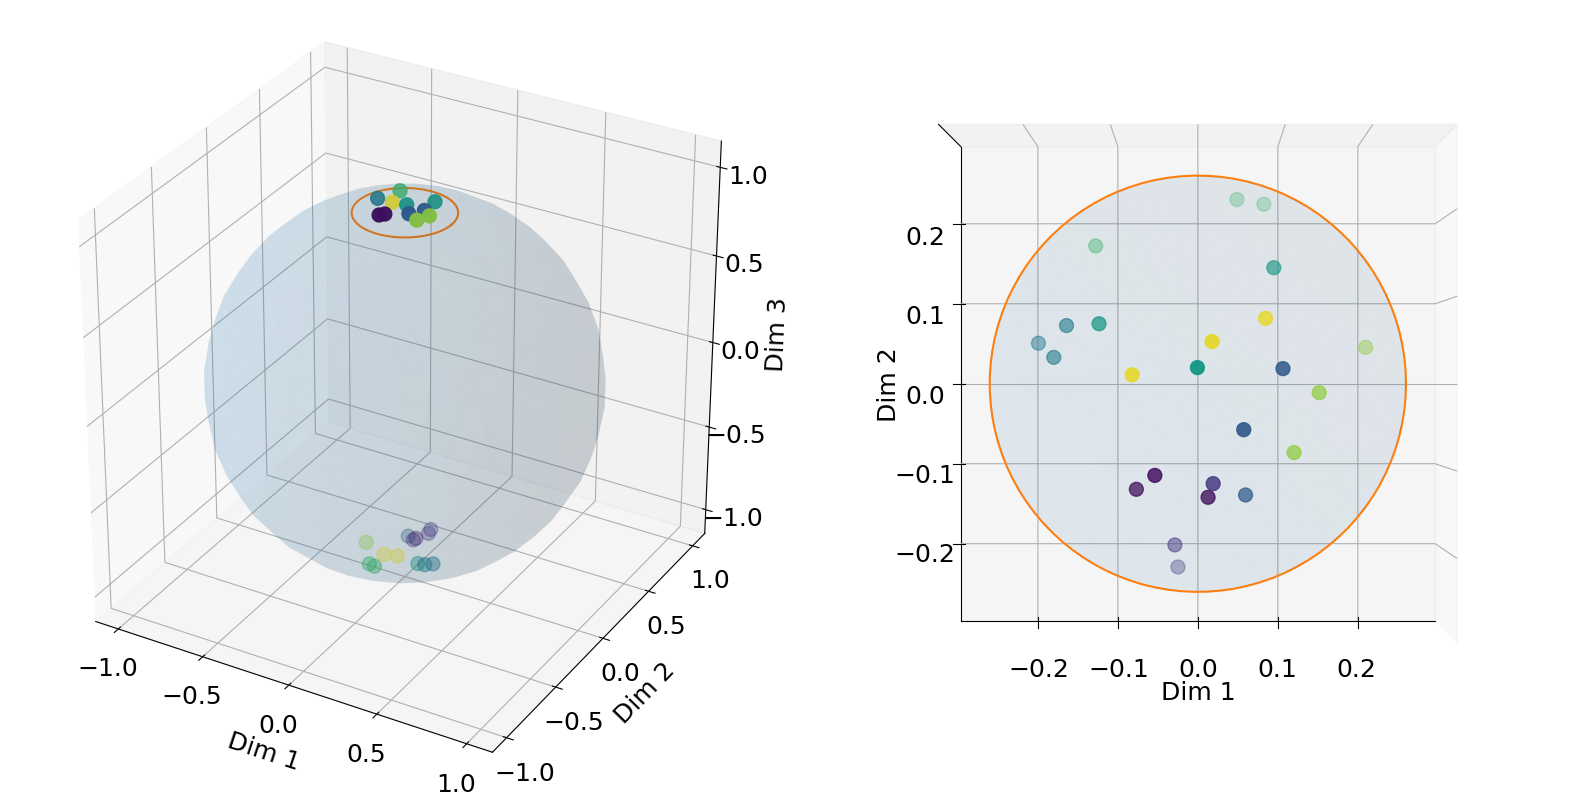

In [ ]:
colors = subjects

fig = plt.figure(figsize=(16, 8))

ax = plt.subplot(1, 2, 1, projection='3d')

u, v = np.mgrid[0:2*np.pi:30j, 0:np.pi:20j]
xx = np.cos(u) * np.sin(v)
yy = np.sin(u) * np.sin(v)
zz = np.cos(v)
ax.plot_surface(xx, yy, zz, alpha=0.1)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=colors, s=100)

cut_angle = np.pi/12
t = np.linspace(0,np.pi*2,100)
r = np.sin(cut_angle)
h = np.cos(cut_angle)
ax.plot(r*np.cos(t), r*np.sin(t), h)

ax.set_xlabel('Dim 1', fontsize=18, labelpad=10)
ax.set_ylabel('Dim 2', fontsize=18, labelpad=10)
ax.set_zlabel('Dim 3', fontsize=18, labelpad=10)
ax.set_xticks([-1, -0.5, 0, 0.5, 1])
ax.set_yticks([-1, -0.5, 0, 0.5, 1])
ax.set_zticks([-1, -0.5, 0, 0.5, 1])
ax.tick_params(axis='both', which='major', labelsize=18, pad=5)
ax.tick_params(axis='both', which='minor', labelsize=18)
ax.set_box_aspect((1, 1, 1) )
# plt.title(title, fontsize=20)
# plt.savefig(title+'.pdf', dpi=300)
# plt.show()

X = X*np.sign(X[:, -1]).reshape(-1, 1) # project to top hemisphere

ax = plt.subplot(1, 2, 2, projection='3d')
u, v = np.mgrid[0:2*np.pi:30j, 0:cut_angle:20j]
xx = np.cos(u) * np.sin(v)
yy = np.sin(u) * np.sin(v)
zz = np.cos(v)
ax.plot_surface(xx, yy, zz, alpha=0.1)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=colors, s=100)
ax.plot(r*np.cos(t), r*np.sin(t), h)

ax.set_xlabel('Dim 1', fontsize=18, labelpad=25)
ax.set_ylabel('Dim 2', fontsize=18, labelpad=25)
ax.set_zticks([])
ax.tick_params(axis='both', which='major', labelsize=18, pad=15)
ax.tick_params(axis='both', which='minor', labelsize=18)
#ax.set_zlabel('Dimension 3', fontsize=16)
ax.view_init(elev=90, azim=-90)
#plt.title(title, fontsize=20)
plt.tight_layout()
plt.savefig(os.path.join(output_folder, 'brain_projected.pdf'), dpi=300)
# plt.show()
